# NLP: Yelp Review to Rating
## :)

In [222]:
# usual libs

import json
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# NLP lib
import nltk
import re, string, collections
from nltk.util import ngrams


# importing torch
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1) #for reproducibility

In [240]:
# mo imports
import itertools
import os

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

import time
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset

from torch.utils.data import DataLoader

import torchtext

from gensim.utils import simple_preprocess

In [226]:
def load_yelp_orig_data():
    PATH_TO_YELP_REVIEWS = './yelp_review_training_dataset.jsonl'

    # read the entire file into a python array
    with open(PATH_TO_YELP_REVIEWS, 'r') as f:
        data = f.readlines()

    # remove the trailing "\n" from each line
    data = map(lambda x: x.rstrip(), data)

    data_json_str = "[" + ','.join(data) + "]"

    # now, load it into pandas
    data_df = pd.read_json(data_json_str)

    data_df.to_csv('./output_reviews_top.csv')
    
load_yelp_orig_data()

/home/tanvee/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,review_id,text,stars
0,0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,1.0
1,1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,5.0
2,2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,5.0
3,3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,5.0
4,4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,1.0


In [231]:
yelp = pd.read_csv('./output_reviews_top.csv')
yelp.head();

/home/tanvee/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [235]:
rev_len = yelp['text'].str.len()
yelp.drop(columns = ['Unnamed: 0'], axis = 1, inplace = True)
yelp.insert(2, "length", rev_len, True)
yelp.head()

,review_id,text,length,stars
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,204.0,1.0
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,1561.0,5.0
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,615.0,5.0
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,407.0,5.0
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,3509.0,1.0


In [242]:
yelp['tokenized'] = [simple_preprocess(str(line), deacc=True) for line in yelp['text']]
yelp.head()

,review_id,text,length,stars,tokenized
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,204.0,1.0,"[total, bill, for, this, horrible, service, ov..."
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,1561.0,5.0,"[adore, travis, at, the, hard, rock, new, kell..."
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,615.0,5.0,"[have, to, say, that, this, office, really, ha..."
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,407.0,5.0,"[went, in, for, lunch, steak, sandwich, was, d..."
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,3509.0,1.0,"[today, was, my, second, out, of, three, sessi..."


In [243]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
yelp['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in yelp['tokenized']]
yelp.head()

,review_id,text,length,stars,tokenized,stemmed_tokens
0,Q1sbwvVQXV2734tPgoKj4Q,Total bill for this horrible service? Over $8G...,204.0,1.0,"[total, bill, for, this, horrible, service, ov...","[total, bill, for, thi, horribl, servic, over,..."
1,GJXCdrto3ASJOqKeVWPi6Q,I *adore* Travis at the Hard Rock's new Kelly ...,1561.0,5.0,"[adore, travis, at, the, hard, rock, new, kell...","[ador, travi, at, the, hard, rock, new, kelli,..."
2,2TzJjDVDEuAW6MR5Vuc1ug,I have to say that this office really has it t...,615.0,5.0,"[have, to, say, that, this, office, really, ha...","[have, to, sai, that, thi, offic, realli, ha, ..."
3,yi0R0Ugj_xUx_Nek0-_Qig,Went in for a lunch. Steak sandwich was delici...,407.0,5.0,"[went, in, for, lunch, steak, sandwich, was, d...","[went, in, for, lunch, steak, sandwich, wa, de..."
4,11a8sVPMUFtaC7_ABRkmtw,Today was my second out of three sessions I ha...,3509.0,1.0,"[today, was, my, second, out, of, three, sessi...","[todai, wa, my, second, out, of, three, sessio..."


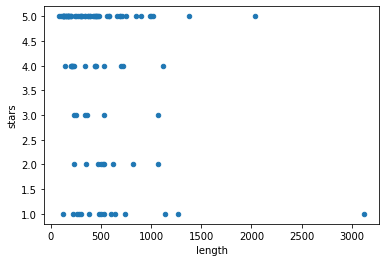

In [236]:
random_plot = yelp.sample(100)
random_plot.plot.scatter(x = 'length', y = 'stars')

ok so length means nothing really, but it looks like there is a bit of a class imbalance as demonstrated by the visualization below

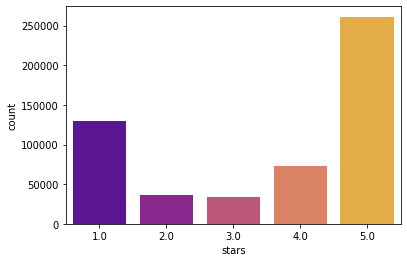

In [237]:
sns.countplot(yelp['stars'], palette = 'plasma')

/home/tanvee/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


stars
1.0    741.227506
2.0    701.123013
3.0    612.270058
4.0    523.488388
5.0    449.518171
Name: length, dtype: float64

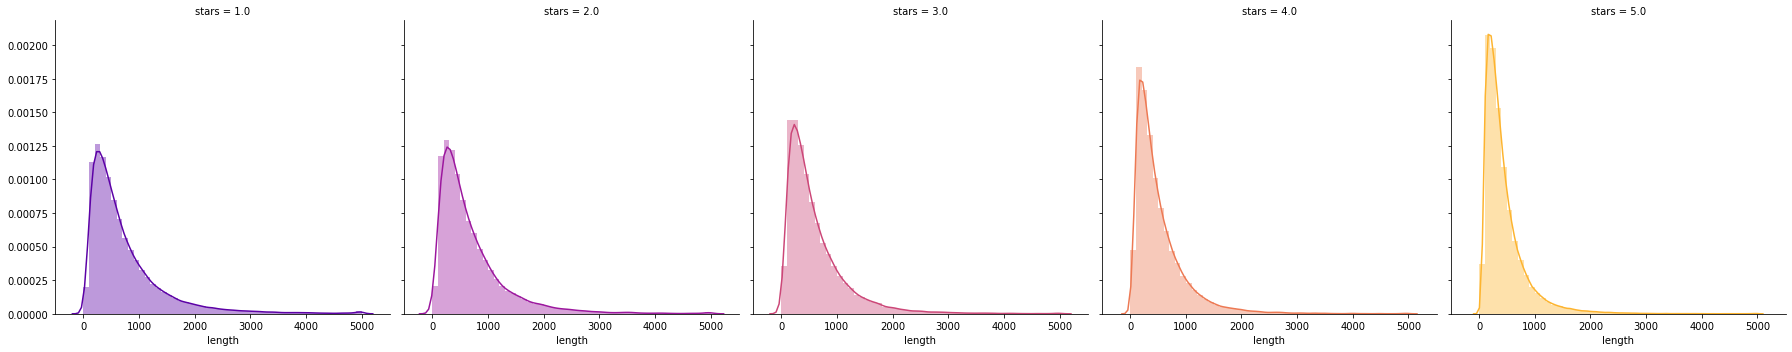

In [238]:
a = sns.FacetGrid(data = yelp, col = 'stars', hue = 'stars', palette='plasma', size=5)
a.map(sns.distplot, "length")
yelp.groupby('stars').mean()['length']

interesting...

In [82]:
# train_size = int(len(yelp) * .7)
# train_posts = yelp['text'][:train_size]
# train_tags = yelp['stars'][:train_size]

# test_posts = yelp['text'][train_size:]
# test_tags = yelp['stars'][train_size:]

In [ ]:
from sklearn.model_selection import train_test_split
# Train Test Split Function
def split_train_test(top_data_df_small, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id', 'stemmed_tokens']], 
                                                        top_data_df_small['sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)

In [162]:
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.dataframe['text'] = self.dataframe['text'].str.lower()
        self.dataframe['text'] = self.dataframe['text'].apply(split)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe.iloc[index]

In [83]:
NGRAMS = 2
BATCH_SIZE = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [84]:
# Model definition

class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [85]:
vocab = train_posts.str.split(' ', expand=True).stack().unique()

In [87]:
VOCAB_SIZE = vocab.shape[0]
EMBED_DIM = 32
NUN_CLASS = 5
model = TextSentiment(VOCAB_SIZE, EMBED_DIM, NUN_CLASS).to(device)

In [218]:
def generate_batch(batch):
    label = torch.tensor([entry['stars'] for entry in batch])
#     print(batch[1], "AHHHHHHHHHHHH")
    text = [entry['text'] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)
    offsets = torch.tensor(offsets[:-1], dtype = torch.int32).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [219]:
def train_func(sub_train_):

    # Train the model
    train_loss = 0
    train_acc = 0
    data = DataLoader(sub_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=generate_batch)
    i = 0
#     print(data)
    for text, offsets, cls in data:
#         print("hjtgfck", text)
        optimizer.zero_grad()
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        output = model(text, offsets)
        loss = criterion(output, cls)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_acc += (output.argmax(1) == cls).sum().item()
        i += 1

    # Adjust the learning rate
    scheduler.step()

    return train_loss / len(sub_train_), train_acc / len(sub_train_)

def test(data_):
    loss = 0
    acc = 0
    data = DataLoader(data_, batch_size=BATCH_SIZE, collate_fn=generate_batch)
    for text in data.dataset:
        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)
        with torch.no_grad():
            output = model(text, offsets)
            loss = criterion(output, cls)
            loss += loss.item()
            acc += (output.argmax(1) == cls).sum().item()

    return loss / len(data_), acc / len(data_)

In [220]:
N_EPOCHS = 5
min_valid_loss = float('inf')

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=4.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_dataset = PandasDataset(yelp[['text', 'stars']][:train_size])

test_dataset = PandasDataset(yelp[['text', 'stars']][train_size:])

train_len = int(len(train_dataset) * 0.95)

sub_train_, sub_valid_ = random_split(train_dataset, (train_len, len(train_dataset) - train_len))
# sub_train_.dataset

In [221]:
for epoch in range(N_EPOCHS):

    start_time = time.time()
    train_loss, train_acc = train_func(sub_train_)
    valid_loss, valid_acc = test(sub_valid_)

    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60

    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\tLoss: {train_loss:.4f}(train)\t|\tAcc: {train_acc * 100:.1f}%(train)')
    print(f'\tLoss: {valid_loss:.4f}(valid)\t|\tAcc: {valid_acc * 100:.1f}%(valid)')

TypeError: expected Tensor as element 0 in argument 0, but got str